In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os.path import basename, dirname
import torch

In [2]:
# Set `res_d`, `network_l`, `num_neurons_d`
base = "/data/sls/temp/johnmwu/contextual-corr-analysis/results1_"
res_fname = {method : base + method for method in 
                {"maxcorr", "mincorr", "linreg", "svcca", "cka"}}

res_d = {}
res_d["maxcorr"] = json.load(open(res_fname["maxcorr"], "r"))
res_d["mincorr"] = json.load(open(res_fname["mincorr"], "r"))
res_d["linreg"] = json.load(open(res_fname["linreg"], "r"))

network_l = [network for network in res_d["maxcorr"]]

num_neurons_d = {}
for network in network_l:
    num_neurons_d[network] = len(res_d["maxcorr"][network])

num_neurons_d

{'/data/sls/temp/belinkov/contextual-corr-analysis/contextualizers/bert_large_cased/ptb_pos_dev.hdf5': 1024,
 '/data/sls/temp/belinkov/contextual-corr-analysis/contextualizers/openai_transformer/ptb_pos_dev.hdf5': 768,
 '/data/sls/temp/belinkov/contextual-corr-analysis/contextualizers/bert_base_cased/ptb_pos_dev.hdf5': 768,
 '/data/sls/temp/belinkov/contextual-corr-analysis/contextualizers/elmo_original/ptb_pos_dev.hdf5': 1024,
 '/data/sls/temp/belinkov/contextual-corr-analysis/contextualizers/calypso_transformer_6_512_base/ptb_pos_dev.hdf5': 1024,
 '/data/sls/temp/belinkov/contextual-corr-analysis/contextualizers/elmo_4x4096_512/ptb_pos_dev.hdf5': 1024}

# MaxCorr, MinCorr, LinReg

### Sorts

In [3]:
rk_methods = {"maxcorr", "mincorr", "linreg"}

In [4]:
neuron_sorts = {network: {} for network in network_l}
for network in network_l:
    for method in rk_methods:
        neuron_sorts[network][method] = [neuron[0] for neuron in res_d[method][network]]

In [5]:
# helper
# network = network_l[0]

# method = "maxcorr"
# ranks = [neuron_sorts[network][method].index(i) for i in range(len(neuron_sorts[network][method]))]
# ranks

# rk_ar = np.stack([
#             [neuron_sorts[network][method].index(i) for i in range(len(neuron_sorts[network][method]))]
#                       for method in rk_methods
# ])

# rk_ar

In [6]:
# Set `rk_ar_d`, `rk_df_d`, `spearman_d`
rk_ar_d = {}
rk_df_d = {}
spearman_d = {}
for network in network_l:
    # rk_ar[method_ix, neuron] = rank
    # need to invert the permutation
    rk_ar = np.stack([
            [neuron_sorts[network][method].index(neuron) for neuron in range(len(neuron_sorts[network][method]))]
                      for method in rk_methods
    ]).T
    rk_df = pd.DataFrame(rk_ar, columns=list(rk_methods))
    
    rk_ar_d[network] = rk_ar
    rk_df_d[network] = rk_df
    spearman_d[network] = rk_df.corr()

In [7]:
for network in network_l:
    print(network)
    print(rk_ar_d[network])
    print(spearman_d[network])

/data/sls/temp/belinkov/contextual-corr-analysis/contextualizers/bert_large_cased/ptb_pos_dev.hdf5
[[706 644 799]
 [ 48  32  35]
 [589 429 436]
 ...
 [325 475 508]
 [912 845 904]
 [869 799 815]]
          maxcorr   mincorr    linreg
maxcorr  1.000000  0.833914  0.822364
mincorr  0.833914  1.000000  0.825473
linreg   0.822364  0.825473  1.000000
/data/sls/temp/belinkov/contextual-corr-analysis/contextualizers/openai_transformer/ptb_pos_dev.hdf5
[[ 62  54  54]
 [553 645 728]
 [ 80  67 159]
 ...
 [695 704 745]
 [760 722 757]
 [302 287 358]]
          maxcorr   mincorr    linreg
maxcorr  1.000000  0.763334  0.807733
mincorr  0.763334  1.000000  0.793264
linreg   0.807733  0.793264  1.000000
/data/sls/temp/belinkov/contextual-corr-analysis/contextualizers/bert_base_cased/ptb_pos_dev.hdf5
[[344 510 579]
 [341 376 196]
 [409 571 383]
 ...
 [350 649 689]
 [380 215 151]
 [148  56 272]]
          maxcorr   mincorr    linreg
maxcorr  1.000000  0.756867  0.769092
mincorr  0.756867  1.000000  0.777

### Distributions



/data/sls/temp/belinkov/contextual-corr-analysis/contextualizers/bert_large_cased/ptb_pos_dev.hdf5:

maxcorr

maxcounts
bert_base_cased                   659
openai_transformer                124
calypso_transformer_6_512_base     88
elmo_4x4096_512                    78
elmo_original                      75
dtype: int64

mmincounts
openai_transformer                325
calypso_transformer_6_512_base    279
elmo_4x4096_512                   199
elmo_original                     156
bert_base_cased                    65
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.833914  0.886658
min  0.833914  1.000000  0.933785
med  0.886658  0.933785  1.000000


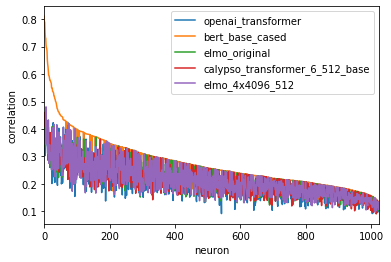

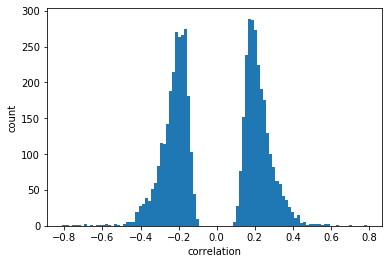


mincorr

maxcounts
bert_base_cased                   659
openai_transformer                124
calypso_transformer_6_512_base     88
elmo_4x4096_512                    78
elmo_original                      75
dtype: int64

mmincounts
openai_transformer                325
calypso_transformer_6_512_base    279
elmo_4x4096_512                   199
elmo_original                     156
bert_base_cased                    65
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.833914  0.886658
min  0.833914  1.000000  0.933785
med  0.886658  0.933785  1.000000


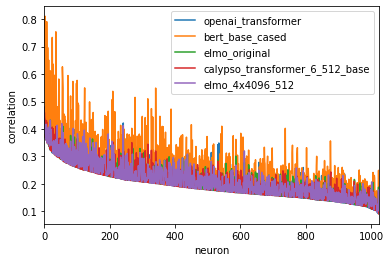

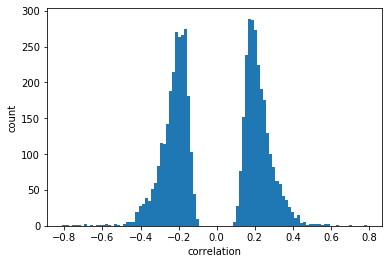


linreg

maxcounts
bert_base_cased    1024
dtype: int64

mmincounts
openai_transformer    1024
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.966028  0.972692
min  0.966028  1.000000  0.979225
med  0.972692  0.979225  1.000000


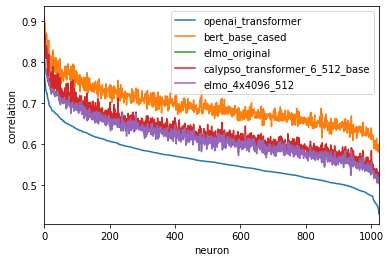

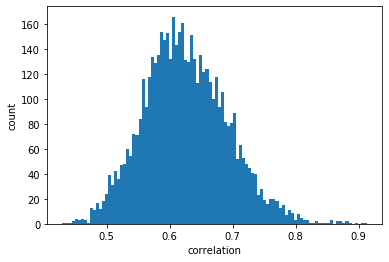



/data/sls/temp/belinkov/contextual-corr-analysis/contextualizers/openai_transformer/ptb_pos_dev.hdf5:

maxcorr

maxcounts
calypso_transformer_6_512_base    270
elmo_4x4096_512                   261
elmo_original                     210
bert_base_cased                    17
bert_large_cased                   10
dtype: int64

mmincounts
bert_base_cased                   382
bert_large_cased                  354
calypso_transformer_6_512_base     13
elmo_4x4096_512                    11
elmo_original                       8
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.763334  0.930568
min  0.763334  1.000000  0.798539
med  0.930568  0.798539  1.000000


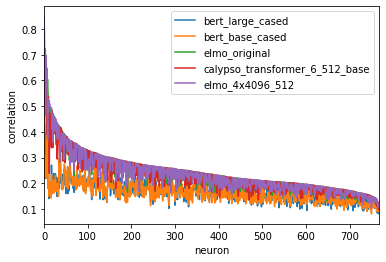

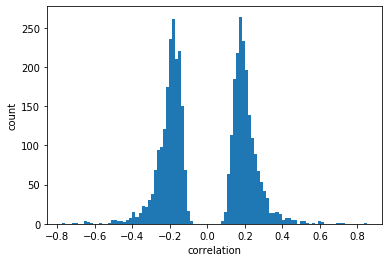


mincorr

maxcounts
calypso_transformer_6_512_base    270
elmo_4x4096_512                   261
elmo_original                     210
bert_base_cased                    17
bert_large_cased                   10
dtype: int64

mmincounts
bert_base_cased                   382
bert_large_cased                  354
calypso_transformer_6_512_base     13
elmo_4x4096_512                    11
elmo_original                       8
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.763334  0.930568
min  0.763334  1.000000  0.798539
med  0.930568  0.798539  1.000000


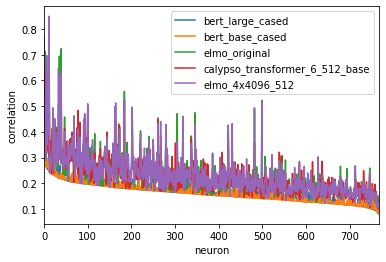

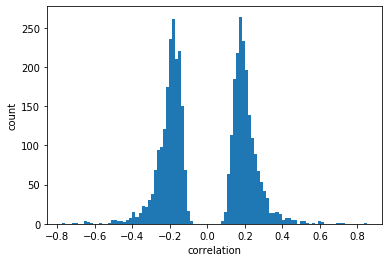


linreg

maxcounts
elmo_original                     416
calypso_transformer_6_512_base    188
elmo_4x4096_512                   164
dtype: int64

mmincounts
bert_large_cased    759
bert_base_cased       9
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.960673  0.996766
min  0.960673  1.000000  0.959002
med  0.996766  0.959002  1.000000


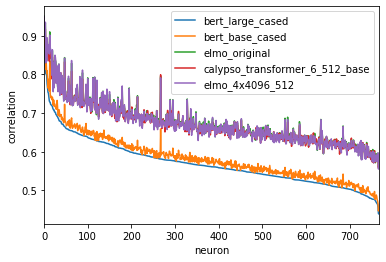

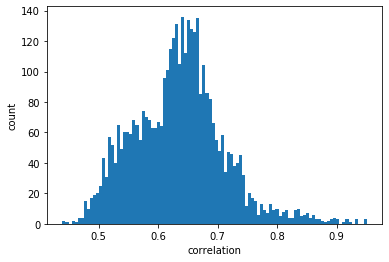



/data/sls/temp/belinkov/contextual-corr-analysis/contextualizers/bert_base_cased/ptb_pos_dev.hdf5:

maxcorr

maxcounts
bert_large_cased                  489
elmo_4x4096_512                    85
openai_transformer                 79
calypso_transformer_6_512_base     63
elmo_original                      52
dtype: int64

mmincounts
openai_transformer                296
calypso_transformer_6_512_base    171
elmo_4x4096_512                   153
elmo_original                     111
bert_large_cased                   37
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.756867  0.828793
min  0.756867  1.000000  0.902188
med  0.828793  0.902188  1.000000


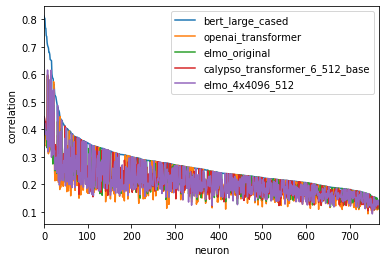

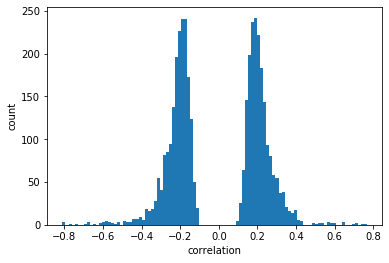


mincorr

maxcounts
bert_large_cased                  489
elmo_4x4096_512                    85
openai_transformer                 79
calypso_transformer_6_512_base     63
elmo_original                      52
dtype: int64

mmincounts
openai_transformer                296
calypso_transformer_6_512_base    171
elmo_4x4096_512                   153
elmo_original                     111
bert_large_cased                   37
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.756867  0.828793
min  0.756867  1.000000  0.902188
med  0.828793  0.902188  1.000000


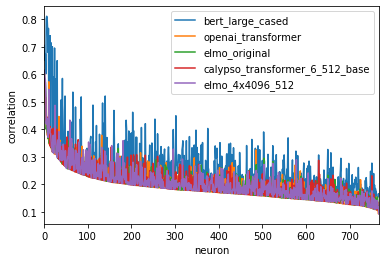

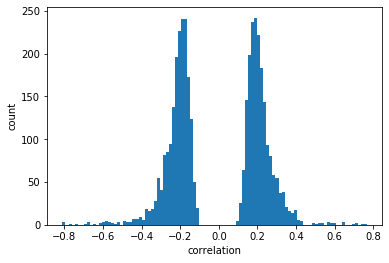


linreg

maxcounts
bert_large_cased    768
dtype: int64

mmincounts
openai_transformer    768
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.933737  0.946542
min  0.933737  1.000000  0.971418
med  0.946542  0.971418  1.000000


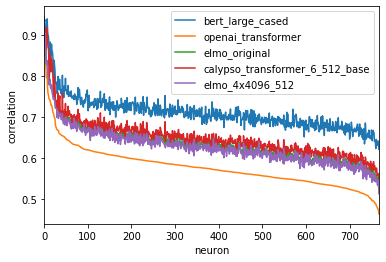

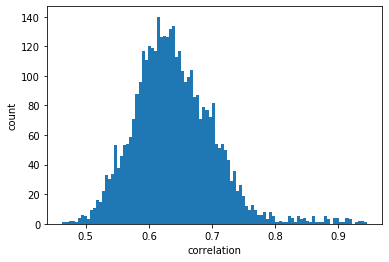



/data/sls/temp/belinkov/contextual-corr-analysis/contextualizers/elmo_original/ptb_pos_dev.hdf5:

maxcorr

maxcounts
elmo_4x4096_512                   550
calypso_transformer_6_512_base    351
openai_transformer                 81
bert_base_cased                    40
bert_large_cased                    2
dtype: int64

mmincounts
bert_large_cased                  373
bert_base_cased                   357
openai_transformer                277
calypso_transformer_6_512_base     15
elmo_4x4096_512                     2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.719712  0.797515
min  0.719712  1.000000  0.803773
med  0.797515  0.803773  1.000000


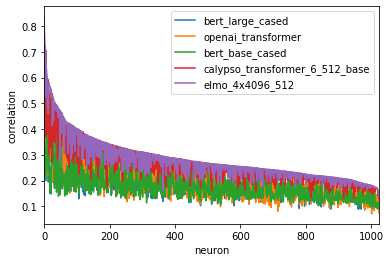

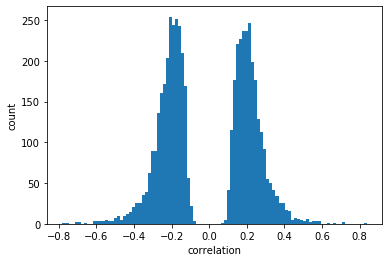


mincorr

maxcounts
elmo_4x4096_512                   550
calypso_transformer_6_512_base    351
openai_transformer                 81
bert_base_cased                    40
bert_large_cased                    2
dtype: int64

mmincounts
bert_large_cased                  373
bert_base_cased                   357
openai_transformer                277
calypso_transformer_6_512_base     15
elmo_4x4096_512                     2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.719712  0.797515
min  0.719712  1.000000  0.803773
med  0.797515  0.803773  1.000000


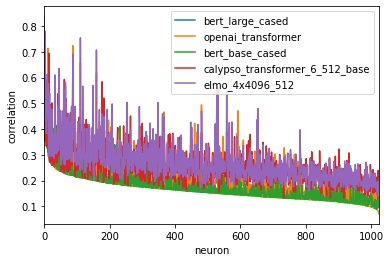

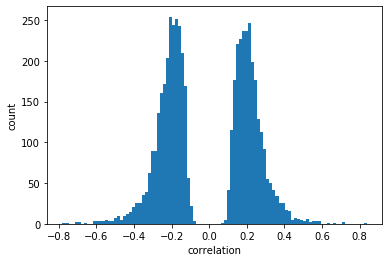


linreg

maxcounts
elmo_4x4096_512                   1023
calypso_transformer_6_512_base       1
dtype: int64

mmincounts
openai_transformer    512
bert_large_cased      452
bert_base_cased        60
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.683009  0.678210
min  0.683009  1.000000  0.968331
med  0.678210  0.968331  1.000000


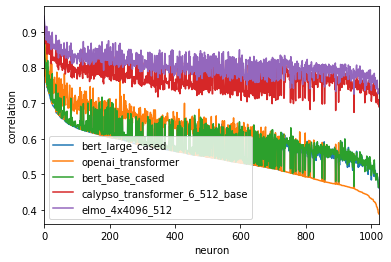

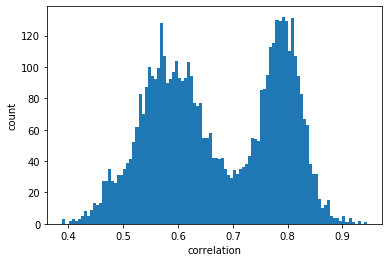



/data/sls/temp/belinkov/contextual-corr-analysis/contextualizers/calypso_transformer_6_512_base/ptb_pos_dev.hdf5:

maxcorr

maxcounts
elmo_4x4096_512       375
elmo_original         357
bert_base_cased       135
openai_transformer    116
bert_large_cased       41
dtype: int64

mmincounts
bert_large_cased      368
openai_transformer    342
bert_base_cased       298
elmo_original          10
elmo_4x4096_512         6
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.766353  0.880929
min  0.766353  1.000000  0.808401
med  0.880929  0.808401  1.000000


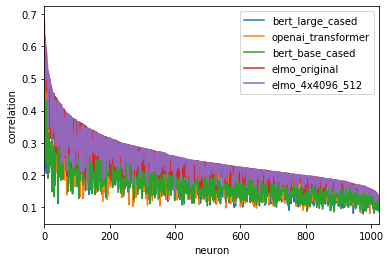

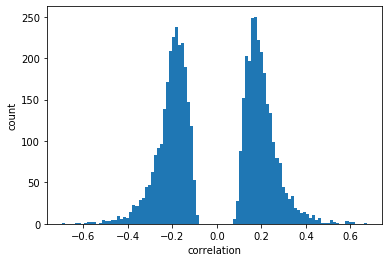


mincorr

maxcounts
elmo_4x4096_512       375
elmo_original         357
bert_base_cased       135
openai_transformer    116
bert_large_cased       41
dtype: int64

mmincounts
bert_large_cased      368
openai_transformer    342
bert_base_cased       298
elmo_original          10
elmo_4x4096_512         6
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.766353  0.880929
min  0.766353  1.000000  0.808401
med  0.880929  0.808401  1.000000


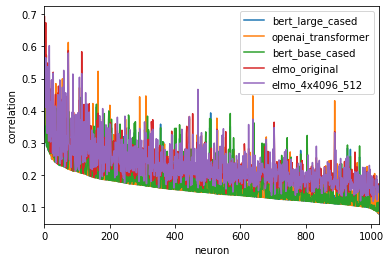

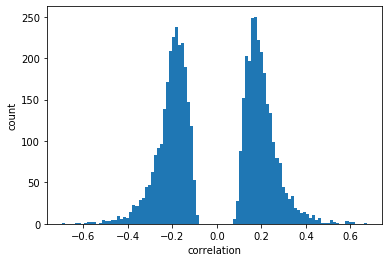


linreg

maxcounts
elmo_4x4096_512    506
elmo_original      491
bert_base_cased     27
dtype: int64

mmincounts
openai_transformer    537
bert_large_cased      475
bert_base_cased         9
elmo_4x4096_512         3
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.272225  0.456933
min  0.272225  1.000000  0.936766
med  0.456933  0.936766  1.000000


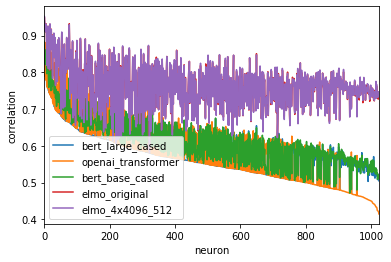

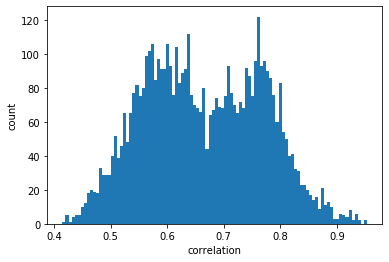



/data/sls/temp/belinkov/contextual-corr-analysis/contextualizers/elmo_4x4096_512/ptb_pos_dev.hdf5:

maxcorr

maxcounts
elmo_original                     517
calypso_transformer_6_512_base    359
openai_transformer                 95
bert_base_cased                    50
bert_large_cased                    3
dtype: int64

mmincounts
bert_large_cased                  391
bert_base_cased                   344
openai_transformer                282
calypso_transformer_6_512_base      6
elmo_original                       1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.727291  0.784406
min  0.727291  1.000000  0.786673
med  0.784406  0.786673  1.000000


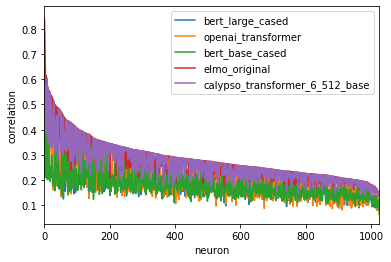

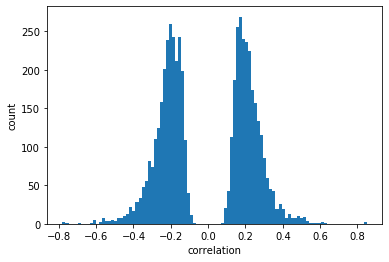


mincorr

maxcounts
elmo_original                     517
calypso_transformer_6_512_base    359
openai_transformer                 95
bert_base_cased                    50
bert_large_cased                    3
dtype: int64

mmincounts
bert_large_cased                  391
bert_base_cased                   344
openai_transformer                282
calypso_transformer_6_512_base      6
elmo_original                       1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.727291  0.784406
min  0.727291  1.000000  0.786673
med  0.784406  0.786673  1.000000


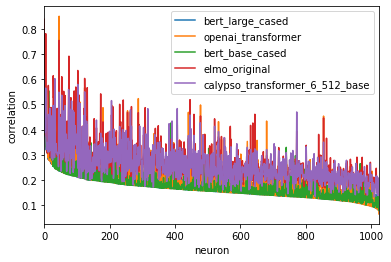

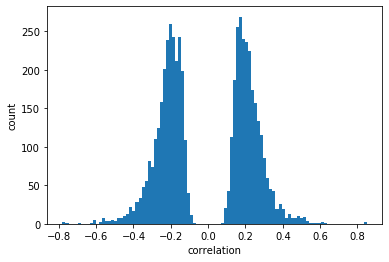


linreg

maxcounts
elmo_original    1024
dtype: int64

mmincounts
openai_transformer    512
bert_large_cased      420
bert_base_cased        92
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.672428  0.655216
min  0.672428  1.000000  0.963284
med  0.655216  0.963284  1.000000


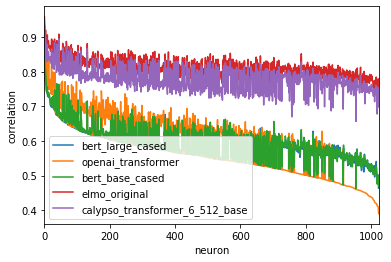

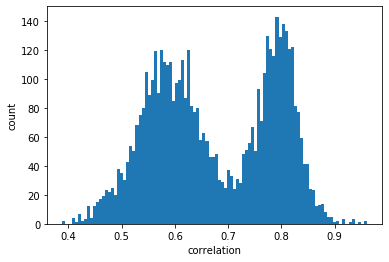

In [29]:
for network in network_l:
    print("\n\n" + network + ":")
    for method in rk_methods:
        print("\n" + method)
        corr_ar = np.stack([
            list(notated_neuron[1].values())
            for notated_neuron in res_d[method][network]
        ])
        corr_df = pd.DataFrame(np.abs(corr_ar), 
                               columns=[basename(dirname(net)) 
                                        for net in network_l if net != network])
        
        print("\nmaxcounts")
        print(corr_df.idxmax(axis=1).value_counts())
        
        print("\nmincounts")
        print(corr_df.idxmin(axis=1).value_counts())
        
        print("\ncorr_df_pctl")
        corr_df_pctl = pd.DataFrame()
        corr_df_pctl["max"] = corr_df.max(axis=1)
        corr_df_pctl["min"] = corr_df.min(axis=1)
        corr_df_pctl["med"] = corr_df.median(axis=1)
        print(corr_df_pctl.rank().corr()) # spearman
        
        corr_df.plot()
        plt.xlabel("neuron")
        plt.ylabel("correlation")
        plt.show()
        
        plt.hist(corr_ar.ravel(), bins=100)
        plt.xlabel("correlation")
        plt.ylabel("count")
        plt.show()

# CKA

In [25]:
cka_d = torch.load(res_fname["cka"])

In [37]:
df = pd.DataFrame(cka_d)
df = df.rename(lambda s: basename(dirname(s)))
df = df.rename(lambda s: basename(dirname(s)), axis=1)
df

,bert_large_cased,openai_transformer,bert_base_cased,elmo_original,calypso_transformer_6_512_base,elmo_4x4096_512
bert_base_cased,0.601784,0.307381,NaN,0.448652,0.343198,0.449093
bert_large_cased,NaN,0.260449,0.601784,0.384843,0.287109,0.385873
calypso_transformer_6_512_base,0.287108,0.363168,0.343199,0.540479,NaN,0.540885
elmo_4x4096_512,0.385873,0.571887,0.449094,0.890262,0.540884,NaN
elmo_original,0.384842,0.570135,0.448652,NaN,0.540479,0.890259
openai_transformer,0.260449,NaN,0.307380,0.570136,0.363168,0.571889


In [38]:
torch.save?